<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/MOEA_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1- Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Install Necessary libraries 

In [3]:
!apt-get install ffmpeg freeglut3-dev xvfb  # For visualization
!pip install stable-baselines3[extra]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
freeglut3-dev set to manually installed.
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (1,145 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19

## Global Imports 

In [4]:
## RL Libraries
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import numpy as np 
import gym
import random

## GA Libraries
import subprocess
import glob
import json
import base64
import csv

from gym import spaces
from datetime import datetime, date

from stable_baselines3 import DDPG
from stable_baselines3 import TD3
from stable_baselines3 import A2C
from stable_baselines3 import PPO

from stable_baselines3.common.vec_env import VecNormalize
from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
from stable_baselines3.common.env_util import make_vec_env

from scipy.optimize import newton, fsolve
from scipy.integrate import quad
from math import sqrt,sin,cos
from random import shuffle, randint
from copy import deepcopy

#for render function
from matplotlib.animation import FuncAnimation
from IPython import display
from IPython.display import display, HTML
from pathlib import Path
from PIL import Image

# 2- Reinforcement Learning Process (RL)

## Parameters

In [5]:
base_path = "/content/gdrive/My Drive/Brachistochrone/RL"
models_path = os.path.join(base_path, "saved_models/")
logs_path = os.path.join(base_path, "logs/")
tensorboard_path = os.path.join(base_path, "barchistostrone_ddpg_tensorboard")

selected_path = ""
best_model_path = ""
log_path = ""
tensorboard_log = ""
normalization_path = ""
stats_path = ""
hypdict_path = ""
SELECTED_MODEL = "generalized_final_1"

"""SET GOAL and MODEL"""
goal = (8.0, -6.0)
#SELECTED_MODEL = 'generalized_final_'+str(Brachistochrone_Env.active_friction)+'_'+str(Brachistochrone_Env.dt)+'_'+str(Brachistochrone_Env.init_angle)+'_'+str(Brachistochrone_Env.sol_space_padding)

## Utility Functions

### Common Functions

In [14]:
def change_selected_model():
  global selected_path, best_model_path, log_path, tensorboard_log, normalization_path, stats_path, hypdict_path
  selected_path = os.path.join(models_path, SELECTED_MODEL)
  best_model_path = os.path.join(models_path, SELECTED_MODEL, "best_model")
  log_path = os.path.join(logs_path, SELECTED_MODEL, "logs")
  tensorboard_log = os.path.join(tensorboard_path, SELECTED_MODEL)
  normalization_path = os.path.join(models_path, SELECTED_MODEL, "normalizer_stat")
  stats_path = os.path.join(normalization_path, "vecnormalize.pkl")
  hypdict_path = os.path.join(models_path, SELECTED_MODEL, "HypDict.txt")

  # Check folders exist on Drive
  os.makedirs(selected_path, exist_ok=True)
  os.makedirs(best_model_path, exist_ok=True)
  os.makedirs(log_path, exist_ok=True)
  os.makedirs(tensorboard_log, exist_ok=True)
  os.makedirs(normalization_path, exist_ok=True)

change_selected_model()


def cycloid(P1,P2,N):
  """Return the path of Brachistochrone curve from (0,0) to (x2, y2).
  The Brachistochrone curve is the path down which a bead will fall without
  friction between two points in the least time (an arc of a cycloid).
  It is returned as an array of N values of (x,y) between (0,0) and (x2,y2).
  """

  # First find theta2 from (x2, y2) numerically (by Newton-Rapheson).
  f = lambda theta: -P2[1]/P2[0] - (1-np.cos(theta))/(theta-np.sin(theta))
  theta2 = newton(f, np.pi/2)

  # The radius of the circle generating the cycloid.
  R = -P2[1] / (1 - np.cos(theta2))

  theta = np.linspace(0, theta2, N)
  x = R * (theta - np.sin(theta))
  y = R * (1 - np.cos(theta))

  # The time of travel
  T = theta2 * np.sqrt(R / Brachistochrone_Env.g)
  return x, y, T


def rect(P1,P2,N):
  """Return the rectilinear straight path from (0,0) to (x2, y2)."""
  x_interval = np.linspace(P1[0],P2[0],N)
  m = float(P2[1] - P1[1])/(P2[0]-P1[0])
  q = P1[1] - (m*P1[0])
  f_y = lambda x: m*x+q
  y = [f_y(x) for x in x_interval]
  T_rett = sqrt(2*(P2[0]**2+P2[1]**2)/(-Brachistochrone_Env.g*P2[1]))
  
  return x_interval,y,T_rett


def plot_solution(x,y,goal,title= None,savef=False):
  if (len(x)!=0):
    #plot results
    cycloid_x, cycloid_y, cycloid_T = cycloid((0,0), goal, len(x))
    rect_x, rect_y, rect_T = rect((0,0), goal, len(x))
    print('Time taken by cycloid = ', cycloid_T)
    print('Time taken by linear solution = ', rect_T)
                
    time_taken = len(x)/(1/Brachistochrone_Env.dt)
    plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
    plt.plot(cycloid_x, -cycloid_y, label='Brachistochrone, time taken =  %fs' %cycloid_T)
    plt.plot(rect_x, rect_y, label='Linear, time taken =  %fs' %rect_T)
    plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
    plt.scatter(x[0], y[0], color = 'red', s = 100.0)
    plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
    plt.annotate('Start', (x[0], y[0]))
    plt.annotate('End', (x[-1], y[-1]))
    plt.annotate('Goal', goal)
    plt.legend()
    plt.xlabel('X-COORDINATE(m)')
    plt.ylabel('Y-COORDINATE(m)')
    if (title is None):
      plt.title('TRAJECTORY')
    else:
      plt.title(title)
    if (savef):
      plot_path = os.path.join(models_path, "%s/%s.png"%(title,title))
      plt.savefig(plot_path, bbox_inches='tight')
    plt.show()
  else:
      print("error: no x,y pairs provided")

### Common Clases

In [15]:
class Schedule(object):

  def value(self, step):
    """
    Value of the schedule for a given timestep

    :param step: (int) the timestep
    :return: (float) the output value for the given timestep
    """
    raise NotImplementedError


class LinearSchedule(Schedule):
  '''
  Linear interpolation between initial_p and final_p over
  schedule_timesteps. After this many timesteps pass final_p is
  returned.

  :param schedule_timesteps: (int) Number of timesteps for which to linearly anneal initial_p to final_p
  :param initial_p: (float) initial output value
  :param final_p: (float) final output value
  '''
  def __init__(self, schedule_timesteps, final_p, initial_p=1.0):
    self.schedule_timesteps = schedule_timesteps
    self.final_p = final_p
    self.initial_p = initial_p


  def value(self, step):
    fraction = min(float(step) / self.schedule_timesteps, 1.0)
    return self.initial_p + fraction * (self.final_p - self.initial_p)


class SaveVecNormalizeCallback(BaseCallback):
  """
  Callback for saving a VecNormalize wrapper every ``save_freq`` steps
  :param save_freq: (int)
  :param save_path: (str) Path to the folder where ``VecNormalize`` will be saved, as ``vecnormalize.pkl``
  :param name_prefix: (str) Common prefix to the saved ``VecNormalize``, if None (default)
      only one file will be kept.
  """
  def __init__(self, save_freq: int, save_path: str, name_prefix:str = None, verbose: int = 0):
    super().__init__(verbose)
    self.save_freq = save_freq
    self.save_path = save_path
    self.name_prefix = name_prefix


  def _init_callback(self) -> None:
    # Create folder if needed
    if self.save_path is not None:
      try:
        os.makedirs(self.save_path, exist_ok=True)
      except:
        pass #folder already exist


  def _on_step(self) -> bool:
    if self.n_calls % self.save_freq == 0:
      if self.name_prefix is not None:
        path = os.path.join(self.save_path, f"{self.name_prefix}_{self.num_timesteps}_steps.pkl")
      else:
        path = os.path.join(self.save_path, "vecnormalize.pkl")
      if self.model.get_vec_normalize_env() is not None:
        self.model.get_vec_normalize_env().save(path)
        if self.verbose > 1:
          print(f"Saving VecNormalize to {path}")
    return True

## Brachistochrone Environment

In [11]:
#discrete action space generating theta variation in [-k;k] interval with step: 0.5
class Brachistochrone_Env(gym.Env):

  dt = 0.2 #HYP
  init_angle = -90.0 #define the initial value for angle of fall
  renderOnReset = False #set to false to speed up training
  active_friction = True #switch friction ON/OFF
  dynamic_friction_coeff = 0.05 #dynamic friction coefficient for friction estimation
  granularity = 0.5 #distance between subsequent angle-variation values from action space
  ylbMagnitude = 1.3 #factor to give extra-dimension along y-dim and relax feasible region
  action_space_padding = 2.5 #>1.3 factor to give more exploration capability to the agent: could be useful in constrained/alternative problems formulation
  g=10 #gravity constant
  
  def __init__(self):
    super(Brachistochrone_Env, self).__init__()
    self.states = np.array([0.0, 0.0, 0.0 ,Brachistochrone_Env.init_angle]) #pos_x, pos_y, vel, #theta from +ve x axis
    self.target_pos = np.array([+8.0, -6.0])
    self.g = -Brachistochrone_Env.g
    self.dt = Brachistochrone_Env.dt
    self.reward = 0.0
    self.tot_reward = 0.0
    self.init_err_position = sqrt((self.target_pos[0])**2 + (self.target_pos[1])**2)
    self.time_steps = 0
    self.renderOnReset = Brachistochrone_Env.renderOnReset
    self.action_space_padding_factor = Brachistochrone_Env.action_space_padding
    self.ylbMagnitude = Brachistochrone_Env.ylbMagnitude
    self.target_steps = self.target_steps_bounder(self.target_pos)
    self.refinementf = False
    
    """counter for render activity during training"""
    self.counter_rend = 200 #RENDER PROGRAMMED SWITCH-OFF
    self.action_seq = []
    
    #defining a feasible reward threshold according to specified dt
    self.reward_threshold = sqrt(0.5*Brachistochrone_Env.g*self.init_err_position)*Brachistochrone_Env.dt
    #for rendering purpose
    self.x_ep = [0]
    self.y_ep = [0]
    self.video = [(0,0)]
    
    """feasible region boundary"""
    self.x_right_boundary = self.target_pos[0]+self.reward_threshold
    self.y_lower_boundary = (Brachistochrone_Env.ylbMagnitude)*self.target_pos[1]-self.reward_threshold

    """
    act_val_high = np.array([90.0])
    act_val_low = np.array([-90.0])
    self.action_space = spaces.Box(low = act_val_low, high = act_val_high, shape = (1,), dtype=np.float32)
    """
    self.action_set, self.theta_bound = self.action_space_init(self.target_pos)
    self.action_space = spaces.Discrete(self.action_set)#discrete action space
    
    obs_val_high = np.array([100.0, 100.0, 1000.0, 0.0])
    obs_val_low = np.array([-100.0, -100.0, -1000.0,-90.0])
    self.observation_space = spaces.Box(low= obs_val_low, high = obs_val_high, shape=(4,), dtype=np.float32)
    #print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>"+str(self.action_space_padding_factor))


  def action_space_init(self,target_p):
    """compute k' as boundary for action space, k'> k, where k is the theoretical derivative of theta angle in optimal cycloid solution"""
    # action_set cardinality is given as a function of granularity
    
    #lower bound time to fall between starting point and goal position 
    goal_distance = self.init_err_position
    t_lb = sqrt(2*goal_distance / Brachistochrone_Env.g)
    #upper bound to angle variation in the path (based on theta variation)
    tot_delta_angle_ub = 180 #°
    
    angle_variation_ub = math.ceil(tot_delta_angle_ub / t_lb / (1/self.dt))
    
    granularity = Brachistochrone_Env.granularity #delta between two consecutive angles
    #action_set_cardinality = math.ceil(2* angle_variation_ub / Brachistochrone_Env.granularity) #variation
    action_set_cardinality = math.ceil(angle_variation_ub / Brachistochrone_Env.granularity)
    
    return action_set_cardinality, angle_variation_ub
    

  def action_discretizer(self,action_value):
    #discretization is used to vary final found solution, and is made on non-normalized action space
    disp =self.theta_bound/self.action_set
    domain = [x for x in np.arange(0,self.action_set+disp,disp)]
    action = min(domain, key=lambda x:abs(x-action_value))
    
    return action
  

  def action_space_norm(self,action):
    granularity = Brachistochrone_Env.granularity
    #action = - self.theta_bound + (action*granularity) #variation
    action = (action*granularity)
    
    return action
  

  def step(self, action):
    dt = self.dt
    # action corresponds to theta
    angle_variation = self.action_space_norm(action)
    original_theta = self.states[3]
    final_theta = original_theta + angle_variation

    original_vel = self.states[2]
    initial_vel_x = original_vel*cos(math.radians(original_theta))
    initial_vel_y = original_vel*sin(math.radians(original_theta))
    
    acceleration = self.g*sin(math.radians(final_theta)) #can be positive or negative
    
    #apply friction if needed
    if (Brachistochrone_Env.active_friction):
      #computing friction actiong along the plane
      ortogonal_acceleration = self.g*cos(math.radians(final_theta))
      friction_deceleration = abs(Brachistochrone_Env.dynamic_friction_coeff* ortogonal_acceleration) # always positive 
      if (acceleration>=0):
        acceleration = acceleration - friction_deceleration
      if (acceleration<0):
        acceleration = acceleration + friction_deceleration
        
    #compute x,y components of acceleration
    acceleration_x = acceleration*cos(math.radians(final_theta)) #
    acceleration_y = acceleration*sin(math.radians(final_theta)) #

    displacement_x = (initial_vel_x*dt) + (0.5*acceleration_x*(dt**2))
    displacement_y = (initial_vel_y*dt) + (0.5*acceleration_y*(dt**2))
    displacement = sqrt(displacement_x**2 + displacement_y**2)

    final_vel_x = initial_vel_x + acceleration_x*dt
    final_vel_y = initial_vel_y + acceleration_y*dt

    final_x = self.states[0] + displacement_x
    final_y = self.states[1] + displacement_y
    final_vel = sqrt(final_vel_x**2 + final_vel_y**2)

    self.states[0] = final_x
    self.states[1] = final_y
    self.states[2] = final_vel
    self.states[3] = final_theta

    #updating path
    self.x_ep.append(final_x)
    self.y_ep.append(final_y)
    self.video.append((final_x,final_y))

    """APPLY POLICY"""
    err_position = sqrt((self.states[0] - self.target_pos[0])**2 + (self.states[1] - self.target_pos[1])**2)

    #r1 define the reward for getting closer to the target 
    r1 = 1 - (err_position/self.init_err_position)
    #r2 define the reward for being fast to get the goal
    r2 = 1 - (self.time_steps/self.target_steps)
    
    """f reward weights"""
    w1= 2 #first try was 1
    w2= 1
    self.reward = w1*r1+w2*r2 # you can think to 1s as weights for scalarization method
    done=False	
    self.time_steps+=1
    if self.time_steps >= self.target_steps:
      #if steps are over and target not reached we give a negative reward equal to negative max step reward
      self.reward = -(w1+w2) 
      #print("goodexit"+str((self.time_steps >= self.target_steps,err_position <= self.reward_threshold)))
      done = True
        
    #verificare se devo fare il replacement di last step con il passo extra
    if self.refinementf:
      #we replace last_pos with optimal inter-position
      last_pos = self.final_step_refinement()
      final_x, self.x_ep[-1], self.states[0] = last_pos[0], last_pos[0], last_pos[0]
      final_y, self.y_ep[-1], self.states[1] = last_pos[1], last_pos[1], last_pos[1]
      self.reward = (w1+w2)*(self.target_steps - self.time_steps)
      done = True
        
    if err_position <= self.reward_threshold and not self.refinementf:#se siamo nel cerchio target
      self.refinementf = self.check_step_refinement()
      if not self.refinementf:
        done = True
      self.reward = (w1+w2)*(self.target_steps - self.time_steps)
        
    if final_x > (self.x_right_boundary) or final_x < -1.0 or final_y > 0.0 or final_y < (self.y_lower_boundary) or displacement_x<0:
      self.reward = -1*(w1+w2)*(self.target_steps - self.time_steps)
      #print("badexit"+str((final_x > (self.x_right_boundary),displacement_x<0)))
      done = True
    
    #new termination condition
    if (self.renderOnReset and self.counter_rend>0):
      print("-------|"+str(final_theta)+";"+str(self.reward)+"|--------------")

    info = {'g_component':acceleration}
    self.tot_reward +=self.reward
    
    return self.states, self.reward, done, info


  def final_step_refinement(self):
    last_pos = np.array([self.x_ep[-1],self.y_ep[-1]])#end of line
    prec_pos = np.array([self.x_ep[-2],self.y_ep[-2]])# start of line
    p_opt = [self.target_pos[0], self.target_pos[1]] #point to project
    
    l2 = np.sum((prec_pos-last_pos)**2)
    #The line extending the segment is parameterized as prec_pos + t (last_pos - prec_pos).
    #The projection falls where t = [(p_opt-prec_pos) . (last_pos-prec_pos)] / |last_pos-prec_pos|^2

    #if you need the point to project on line extention connecting prec_pos and last_pos
    t = np.sum((p_opt - prec_pos) * (last_pos - prec_pos)) / l2

    #if you need to ignore if p_opt does not project onto line segment
    if t > 1 or t < 0:
      return(last_pos[0],last_pos[1])

    #if you need the point to project on line segment between prec_pos and last_pos or closest point of the line segment
    t = max(0, min(1, np.sum((p_opt - prec_pos) * (last_pos - prec_pos)) / l2))

    projection = prec_pos + t * (last_pos - prec_pos)
    
    return(round(projection[0],3),round(projection[1],3))


  def check_step_refinement(self):
    if (self.states[0]>self.target_pos[0]-self.reward_threshold and self.states[0]<self.target_pos[0] and self.states[1]<self.target_pos[1]+self.reward_threshold and self.states[1]>self.target_pos[1] -self.reward_threshold):
      return True
    else:
      return False
      
      
  def reset(self):
    #render and reset trace
    self.counter_rend =self.counter_rend - 1
    
    if (self.renderOnReset== True and self.counter_rend>0):
      self.render(mode="auto")
      print("<<<TOT. EP. REWARD: %f>>>"%(self.tot_reward))
    
    self.x_ep.clear()
    self.y_ep.clear()
    self.time_steps = 0
    self.reward = 0.0
    self.tot_reward = 0.0
    self.refinementf = False
    self.states = np.array([0.0, 0.0, 0.0 ,Brachistochrone_Env.init_angle])

    return self.states

  
  def target_steps_bounder(self,target_pos: tuple):
    """trying to cut all sub-optimal solutions dinamically selecting max. steps per episode from trivial linear solution"""
    
    if (target_pos[1]>=0):
      raise Exception("error: unfeasible path given")
    
    L = target_pos[0] #we suppose paths are built between (0,0) and (x_t,y_t) for normalization reasons
    H = target_pos[1]
    T_rett = sqrt(2*(L**2+H**2)/(-Brachistochrone_Env.g*H))
    
    #this method must return number of maximum steps
    N_target_steps = T_rett/self.dt*(self.action_space_padding_factor)
    
    return int(math.ceil(N_target_steps))
  

  @staticmethod
  def get_steps_bounder(target_pos: tuple):
    if (target_pos[1]>=0):
      raise Exception("error: unfeasible path given")
    
    L = target_pos[0] #we suppose paths are built between (0,0) and (x_t,y_t) for normalization reasons
    H = target_pos[1]
    T_rett = sqrt(2*(L**2+H**2)/(-Brachistochrone_Env.g*H))
    
    #this method must return number of maximum steps
    N_target_steps = T_rett/self.dt*(Brachistochrone_Env.action_space_padding)
    return int(math.ceil(N_target_steps))
      
  def render(self,mode='human'):
    if (len(self.x_ep)!=0):
      goal = self.target_pos
      time_taken = self.time_steps*(self.dt)
      
      x = np.array(self.x_ep)
      y = np.array(self.y_ep)
      
      circle1 = plt.Circle(goal, self.reward_threshold, color='r', fill=False)
      fig, ax = plt.subplots()
      
      plt.plot(x,y , label = 'Path by RL agent, time taken =  %fs' %time_taken)
      plt.scatter(x[-1], y[-1], color = 'green', s = 100.0)
      plt.scatter(x[0], y[0], color = 'red', s = 100.0)
      plt.scatter(goal[0], goal[1], color = 'blue', s=100.0)
      
      ax.add_patch(circle1)
      
      plt.annotate('Start', (x[0], y[0]))
      plt.annotate('End', (x[-1], y[-1]))
      plt.annotate('Goal', goal)
      plt.legend()
      
      """draw boundary of feasible region"""
      plt.axhline(y=self.y_lower_boundary, color='r', linestyle='-')
      plt.axvline(x=self.x_right_boundary, color='r', linestyle='-')

      plt.xlabel('X-COORDINATE(m)')
      plt.ylabel('Y-COORDINATE(m)')
      plt.title('TRAJECTORY')
      plt.show()

### Utility Function Parse Metadata. Dependency Brachistochrone Class

In [13]:
def ParseMetadataFile(env_class = Brachistochrone_Env, filepath =""):
  plist= [k for k in vars(env_class) if isinstance(k, str)]
  hyp= [elem for elem in plist if not elem.startswith('_') and not callable(getattr(Brachistochrone_Env,elem))]
  hyp_values= [getattr(env_class,par) for par in hyp]
  tuples = zip(hyp,hyp_values)
  
  with open(filepath, "a+") as hypdata:
    hypdata.write("<<<MODEL HYPER-PARAMETERS>>>\n\n#env params#\n")
    
    for strl,val in tuples:
      nline= "%s:%f\n"%(strl,val)
      hypdata.write(nline)
    hypdata.write("#wrapper params#\n\n")

## Reinforcement Learning Base Solution Builder

In [17]:
class RLBaseSolutionBuilder:
  
  def __init__(self, env_class, target_pos =(8.0, -6.0) ):
    self.target_pos = target_pos
    self.current_model = None
    self.current_model_name = None
    self.env_class = env_class
    env_class.renderOnReset= False
    env_class.dt = 0.1 #the smaller dt is,the slower is training the agent, the higher is resolution


  def TrainNewAgent(self,training_steps = 15000, model_name="test_model", renderOnReset=False):
    #allena un nuovo agent sul env inizializzato e lo salva se specificato con tanto di stats per la normalizzazione
    #wrapping fro obs_space and action_space normalization
        
    self.current_model_name = model_name
    SELECTED_MODEL = self.current_model_name
    change_selected_model()
    base_env = self.env_class()

    if (renderOnReset):
      base_env.renderOnReset=True
    
    self.env = make_vec_env(lambda:base_env , n_envs=1)
    self.env = VecNormalize(self.env, training=True ,norm_obs=True, norm_reward=True)
    save_vec_normalize = SaveVecNormalizeCallback(save_freq=1, save_path=normalization_path)
    self.learning_rate_schedule = LinearSchedule(training_steps,0.000125,0.1)
    
    eval_callback = EvalCallback(self.env, 
                                 best_model_save_path=selected_path, 
                                 callback_on_new_best=save_vec_normalize,
                                 log_path=log_path, 
                                 eval_freq=100,
                                 deterministic=True, 
                                 render=False)

    self.current_model = PPO('MlpPolicy', 
                             env =self.env, 
                             verbose=0,
                             batch_size=32, #n_steps= NSTEPS, batch_size = BATCHSIZE,
                             gamma= 0.99, 
                             learning_rate=self.learning_rate_schedule.value,
                             policy_kwargs= dict(net_arch=[600, 600, 300]), 
                             tensorboard_log=tensorboard_log)

    print("training model %s start..."%{model_name})
    self.current_model.learn(total_timesteps=training_steps, log_interval=1, callback=eval_callback)
    self.env.set_attr("renderOnReset",False)
    print("training model %s finish"%{model_name})
    ParseMetadataFile(self.env_class, filepath=hypdict_path)
      

  def LoadAgentModel(self, model_name):
    #carica dalla memoria un agent pre-trainato
    try:
      base_env = self.env_class()
      base_env.renderOnReset=False
      self.env = make_vec_env(lambda: base_env, n_envs=1)
      #recall statistics for normalizer
      self.env = VecNormalize.load(stats_path, self.env)
      """model loading"""
      self.current_model = PPO.load(best_model_path, env=self.env)
      self.current_model_name= model_name
    except:
      print("no model/env found, loading failed\n")

  def ValidateAgent(self, save=False):
    #esegue l'agent sull'env, costruendo e graficando la candidata base solution
    position= [] #list of tuples containing subsequent positions
    x = [] # x steps
    y = [] #y values associated
    steps = 0
    actions = []
    observations = []
    episodic_reward = []
    
    #  do not update them at test time
    self.env.training = False
    # reward and input-state normalization is not needed at test time
    self.env.norm_obs = False
    self.env.norm_reward = False
    obs= self.env.reset()

    while True:
      action= self.current_model.predict(obs, deterministic = True)
      obs, reward, done, info = self.env.step(action)
      observations.append(obs)
      new_value = obs[0] #the array from which to extract new piece of path information
      """new_value[1]: pos_x new_value[2]: pos_y"""
      position.append((new_value[0],new_value[1]))
      
      if done==False:
        x.append(new_value[0])
        y.append(new_value[1])
    
      episodic_reward.append(reward)
      actions.append(action)
      steps+=1

      if done:
        """solution refinement"""
        
        #check for starting point, sometimes input space normalization makes it lost
        if (x[0]!=0 or y[0]!=0):
          x.insert(0,0)
          y.insert(0,0)
        
        plot_solution(x,y,self.target_pos,title=self.current_model_name,savef=save)
        
        print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
        print("Steps taken: " + str(steps))
        print("Time taken: " , steps*self.env.get_attr("dt"))
        break
  

  def GetBaseSolution(self):
    self.solution_vector=[]
    obs = self.env.reset()
    
    while True:
      action= self.current_model.predict(obs, deterministic = True)
      self.solution_vector.append(action[0])
      obs, reward, done, info = self.env.step(action)
      new_value = obs[0] #the array from which to extract new piece of path information
      
      if done:
        return self.solution_vector
  

  def GetEnv(self):
    return self.env

## Optimizer Middleware Manager

Middle logic class for hybrid optimizer construction


In [18]:
class OptimizerMiddlewareManager:
  
  #acts on standard deviation for gaussian random variable sampling [0;1]
  amountOfVariation = 0.05 #FOR CAST SOLUTIONS [0;0.1], FOR BASE SOLUTION [0;1]
  
  def __init__(self,env,base_solution, pop_size=100):
      self.env = env
      self.pop_cardinality = pop_size
      self.base_solution = base_solution
      self.discretizer = env.get_attr("action_discretizer")[-1]
      self.amountOfVariation = OptimizerMiddlewareManager.amountOfVariation
  
  
  def base_solution_cast(self):
      #method needed for domain adaptation
      obs = env.reset()#reset the whole environment
      self.cast_base_solution = []
      for action in self.base_solution:
          obs, reward, done, info = env.step(action)
          new_value = obs[0] #the array from which to extract new piece of path information
          if done==False:
              self.cast_base_solution.append((new_value[0],new_value[1]))

          if done:
              try:
                  #check for starting point, sometimes input space normalization makes it lost
                  if (self.cast_base_solution[0]!=(0.0,0.0)):
                      self.cast_base_solution.insert(0,(0.0,0.0))
                  return self.cast_base_solution
              except:
                  print("WARNING : empty model\n")
              break

                  
  def NoiseApply(self,pop_ind_value, castedversion=False):
      #print(pop_ind_value)
      if (castedversion):
          noise = random.gauss(0,self.cast_sigma)
          return np.array([pop_ind_value[0],pop_ind_value[1]+noise])
          
      else:
          noise = random.gauss(0,self.sigma)
          pop_ind_value = np.array([self.discretizer(pop_ind_value+noise)])
      return pop_ind_value


  def InitialPopulationCreator(self, amntOfVar=None):
      if amntOfVar is not None:
          self.amountOfVariation = amntOfVar
      #building variation around candidate optimal solution to feed next evolutionary optimizer
      init_population = []
      self.sigma = (max(self.base_solution)- min(self.base_solution))[0]*(self.amountOfVariation)
      for i in range(self.pop_cardinality):
          elem_sol=list(map(self.NoiseApply,self.base_solution))
          init_population.append(elem_sol)
      init_population = np.array(init_population)
      self.init_population = init_population
      return init_population
  

  def InitialPopulationRender(self):
      #warning: some randomly built solutions could be not feasible and eventually not renderizable
      try:
          for sol in self.init_population:
              obs = env.reset()#reset the whole environment
              x=[]
              y=[]
              for action in sol:
                  obs, reward, done, info = env.step(action)
                  new_value = obs[0] #the array from which to extract new piece of path information
                  if done==False:
                      x.append(new_value[0])
                      y.append(new_value[1])
                  if done:
                      try:
                          #check for starting point, sometimes input space normalization makes it lost
                          if (x[0]!=0 or y[0]!=0):
                              x.insert(0,0)
                              y.insert(0,0)
                          """data visualization"""
                          plot_solution(x,y,goal,title="CANDIDATE SOLUTION",savef=False)
                      except:
                          print("WARNING : empty model\n")
                      break 
      except:
              print("error: no InitialPopulation was initialized\n")


  def TranslatedPopulationRender(self):
      try:
          for XYpairs in self.cast_pop:
              Xs,Ys = zip(*XYpairs)
              plt.plot(Xs,Ys,label= "variated solution in translated domain")
              plt.scatter(Xs[-1], Ys[-1], color = 'green', s = 100.0)
              plt.scatter(Xs[0], Ys[0], color = 'red', s = 100.0)
              plt.annotate('Start', (Xs[0], Ys[0]))
              plt.annotate('End', (Xs[-1], Ys[-1]))
              plt.axhline(y=self.env.get_attr("y_lower_boundary"), color='r', linestyle='-')
              plt.axvline(x=self.env.get_attr("x_right_boundary"), color='r', linestyle='-')
              plt.show()
      except:
          print("error: no cast population was initialized, call CreatePopInTranslatedDomain method\n")
  

  def ExportPopulationToCSV(self, folder=selected_path, file='data.csv'):
    file = os.path.join(folder, file)

    try:
        # solution numpy array is shaped pop_cardinality * sol_lenght * 1(single-alement-array for single action modleing)
        self.init_population = np.array([np.array([x[0] for x in elem]) for elem in self.init_population])
    except:
        print("error: no InitialPopulation was initialized\n")
    
    np.savetxt(file, self.init_population,fmt='%10.3f', delimiter=",")


  def ImportPopulationFromCSV(self, folder=selected_path, file='data.csv'):
    file = os.path.join(folder, file)

    try:
        #data are deserialized to 2d dimension and not 3d, as RL agent asks, cause we intend to exploit data in next step of optimiz. pipeline
        self.init_population = np.genfromtxt(file, delimiter=',')
        #for elem_sol in self.init_population:
        self.init_population = [ [np.array([varr]) for varr in elem_sol] for elem_sol in self.init_population ]
    except:
        print("error: init file not found or not accessible\n")
          

  def CreatePopInTranslatedDomain(self, amntOfVar=None):
      #take an initial solution in delta angle domain and creates (x,y) pairs individuals
      if amntOfVar is not None:
          self.amountOfVariation = amntOfVar
      self.cast_pop=[]
      try:
          _, y_values = zip(*self.cast_base_solution)
          self.cast_sigma = (max(y_values)- min(y_values))*(self.amountOfVariation)
          for i in range(self.pop_cardinality):
              #elem_sol = [np.array([varr[0],varr[1]+noise]) for varr in self.cast_base_solution]
              elem_sol=list(map(self.NoiseApply,self.cast_base_solution,np.full(len(self.cast_base_solution),True)))
              elem_sol.insert(0,np.array([0.0,0.0]))
              elem_sol.append(tuple(self.env.get_attr("target_pos")[0]))
              self.cast_pop.append(elem_sol)

          cast_population = np.array(self.cast_pop)
          self.cast_pop = cast_population
          return cast_population
      except:
          print("error: no cast base solution was initialized, call base_solution_cast method\n")
  
  
  def GetInitPopData(self):
      try:
          """return initial pop, pop cardinality and gene size for MOEA"""
          return self.cast_pop, self.cast_pop.shape[0], self.cast_pop.shape[1]
      except:
          print("error: no cast population was initialized, call CreatePopInTranslatedDomain method\n")
  
  

## Test Section Reinforcement Learning

### Generation of new Training Set (3 Generations)

In [ ]:
#grid hyperparametrization
for Brachistochrone_Env.active_friction in [True,False]:
    for Brachistochrone_Env.dt in [0.1,0.2]:
        for Brachistochrone_Env.init_angle in [-90,-65]:
            for Brachistochrone_Env.sol_space_padding in [1.5,2.5]:
                for Brachistochrone_Env.action_space_padding in [2.0,3.0]:
                    """HYP FOR AGENT TRAINING"""
                    goal = (8.0, -6.0)
                    SELECTED_MODEL = 'generalized_final_3G_nrn_2_'+str(Brachistochrone_Env.active_friction)+'_'+str(Brachistochrone_Env.dt)+'_'+str(Brachistochrone_Env.init_angle)+'_'+str(Brachistochrone_Env.sol_space_padding)+'_'+str(Brachistochrone_Env.action_space_padding)
                    change_selected_model()

                    TOT_STEPS = 150000
                    Brachistochrone_Env.renderOnReset= False
                    """"""""""""
                    env = Brachistochrone_Env()
                    learning_rate_schedule = LinearSchedule(TOT_STEPS,0.000125,0.1)
                    print(env.target_pos)
                    env = make_vec_env(lambda: env, n_envs=1)

                    #wrapping fro obs_space and action_space normalization
                    env = VecNormalize(env, training=True ,norm_obs=True, norm_reward=False)
                    #callback initialization for online update of normalization stats
                    save_vec_normalize = SaveVecNormalizeCallback(save_freq=1, save_path=normalization_path)


                    eval_callback = EvalCallback(env, best_model_save_path=selected_path, callback_on_new_best=save_vec_normalize,
                                                 log_path=log_path, eval_freq=500,
                                                 deterministic=True, render=False)
                    #PPO algorithm is made to discourage radical changes of the policy among differrent episodes, this makes the algorithm more sensible to local minima
                    #provare altri algoritmi PPo2, ACKTR
                    model = PPO('MlpPolicy', env =env, verbose=0,
                                gamma= 0.99, learning_rate=learning_rate_schedule.value,
                                policy_kwargs= dict(net_arch=[600, 600, 300]), tensorboard_log=tensorboard_log)


                    model.learn(total_timesteps=TOT_STEPS, log_interval=1, callback=eval_callback)
                    #build metadata
                    metad = ParseMetadataFile(env_class = Brachistochrone_Env,filepath=hypdict_path)

                    print("<<<END OF %s MODEL TRAINING>>>"%(SELECTED_MODEL))

### Automation Test Results for Normalized input and Rewards

In [ ]:
#grid hyperparametrization
for Brachistochrone_Env.active_friction in [True,False]:
    for Brachistochrone_Env.dt in [0.1,0.2]:
        for Brachistochrone_Env.init_angle in [-90,-65]:
            for Brachistochrone_Env.sol_space_padding in [1.5,2.5]:
                for Brachistochrone_Env.action_space_padding in [2.0,3.0]:
                    goal = (8.0, -6.0)
                    SELECTED_MODEL = 'generalized_final_3G_nrn_2_'+str(Brachistochrone_Env.active_friction)+'_'+str(Brachistochrone_Env.dt)+'_'+str(Brachistochrone_Env.init_angle)+'_'+str(Brachistochrone_Env.sol_space_padding)+str(Brachistochrone_Env.action_space_padding)
                    change_selected_model()

                    #building found optimal path
                    Brachistochrone_Env.renderOnReset=False
                    env = Brachistochrone_Env()
                    env = make_vec_env(lambda: env, n_envs=1)
                    """load stats and env config"""
                    try:
                        #recall statistics for normalizer
                        env = VecNormalize.load(stats_path, env)
                        #  do not update them at test time
                        env.training = False
                        # reward and input-state normalization is not needed at test time
                        env.norm_obs = False
                        env.norm_reward = False
                        """model loading"""
                        model = PPO.load(best_model_path, env=env)
                    except:
                        print("no model found")
                        continue

                    position= [] #list of tuples containing subsequent positions
                    x = [] # x steps
                    y = [] #y values associated
                    steps = 0
                    actions = []
                    observations = []
                    #BUILD SOLUTION
                    #print("Episode {}".format(ep + 1))
                    episodic_reward = []


                    #we have to force target into environment as it must be constant and specified to AI agent

                    obs = env.reset()
                    print("Inital obs: "  +str(obs))

                    """SOLUTION RECONSTRUCTION"""
                    while True:
                        action= model.predict(obs, deterministic = True)
                        obs, reward, done, info = env.step(action)
                        observations.append(obs)
                        new_value = obs[0] #the array from which to extract new piece of path information
                        """new_value[1]: pos_x new_value[2]: pos_y"""
                        position.append((new_value[0],new_value[1]))
                        if done==False:
                            x.append(new_value[0])
                            y.append(new_value[1])
                        episodic_reward.append(reward)
                        actions.append(action)
                        steps+=1
                        #print('obs=', obs, 'reward=', reward, 'done=', done)
                        if done:
                            try:
                                """solution refinement"""
                                #clean last step from the history
                                x.pop()
                                y.pop()
                                position.pop()
                                #check for starting point, sometimes input space normalization makes it lost
                                if (x[0]!=0 or y[0]!=0):
                                    x.insert(0,0)
                                    y.insert(0,0)
                                print(x)
                                print(y)
                                plot_solution(x,y,goal,title=SELECTED_MODEL,savef=True)
                                print("Goal reached!", "episodic-reward=", np.sum(episodic_reward))
                                print("Steps taken: " + str(steps))
                                print("Time taken: " , steps*Brachistochrone_Env.dt)
                            except:
                                print("%s is empty"%(SELECTED_MODEL))
                            break

# 3- Multi Objective Evolutionary Algorithm (MOEA)

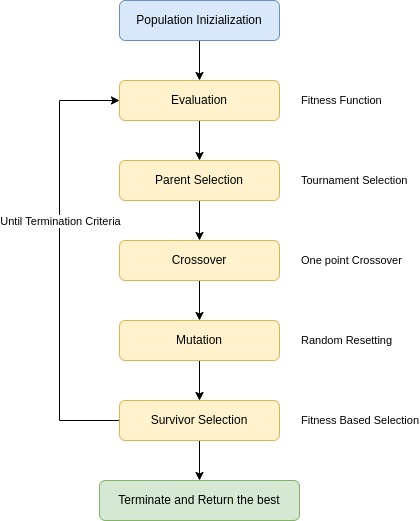

## Parameters

In [30]:
ga_selection_method = ["Tournament", "NSGA2"]
ga_objectives = ["Time", "Distance"]
ga_n_dimensions = 2
ga_n_individuals = 19
ga_n_generations = 10000
ga_n_points = 15

# Percentage
ga_ps = 0.3 # Selection
ga_pc = 0.5 # Crossover
ga_pm = 0.01 # Mutation
ga_elite = 0.1 # Selected group that is superior to the rest of a individuals

ga_p_variable = True # Varied the probability

# Boundaries 
ga_xl = 0 # left boundary
ga_xr = 1 # rigth boundary
ga_yu = 1 # up boundary
ga_yl = -1 # low boundary
ga_limits = [ga_xl, ga_yl]
ga_weights = [0.4, 0.6] # Time, Distance
ga_height = 1
ga_width = 1

ga_seed = 1

ga_random = False # Creation of Random Population
ga_show_info = True # See Important Info
ga_show_debug = False # See Specific info to help the visualization for develop
ga_show_plot = False # See Description Prints
ga_max_frames = 20
ga_parents = []
ga_new_individuals = []

ga_base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA"
ga_counter = 0
ga_misc_runs_dir = ""
ga_evolution_dir = ""
ga_objectives_dir = ""

date_string = date.today()
base_name = f'Env_({date_string})_ind={ga_n_individuals}_gen={ga_n_generations}_pts={ga_n_points}'

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

## Common Functions

In [18]:
# Set the start config
def initConfig(folder=ga_misc_runs_dir, file='config.json', set_global=False, show_debug=False):
  file = os.path.join(folder, file)

  if Path(file).is_file():
    with open(file, "r") as f:
      myJSON = json.loads(f.read()) # Reading from file
      f.close()
  else:
    globals__ = globals()
    config = {}

    # Inside our Genetic algorithm, we declare all global values as ga_*
    # Easier for search and get all the config values
    for key, value in sorted(globals__.items()):
      if key.startswith('ga_'):
        config[key] = value

    myJSON = json.dumps(config, indent = 4) 

    with open(file, "w") as f:
        f.write(myJSON)
        f.close()

  if ga_show_debug:
    print("\n----------------------------------------------------------------")
    print(f'Configuration: \n{file}')
    print(myJSON)
    print("Write successful")
    print("----------------------------------------------------------------\n")

  if set_global:
    # set_global = False as default, save the new configuration but don't update the global values
    # set_global = True to use the new config from file 
    globals().update(myJSON)


# Create environment Folders
def makeFolders():
  global date_string, base_name, ga_evolution_dir, ga_objective_dir, ga_misc_runs_dir

  date_string = date.today()
  base_name = f'Env_({date_string})_ind={ga_n_individuals}_gen={ga_n_generations}_pts={ga_n_points}'
  ga_evolution_dir = os.path.join(ga_base_path, "evolution/" + base_name)
  ga_objective_dir = os.path.join(ga_base_path, "objectives/" + base_name)
  ga_misc_runs_dir = os.path.join(ga_base_path, "misc_runs/" + base_name)

  Path(ga_evolution_dir).mkdir(parents=True, exist_ok=True)
  Path(ga_objective_dir).mkdir(parents=True, exist_ok=True)
  Path(ga_misc_runs_dir).mkdir(parents=True, exist_ok=True)


# Normalize an array between given min and max values 
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal


# Write data into a CSV
def exportCSV(data, folder=ga_misc_runs_dir, file='data.csv'):
  file = os.path.join(folder, file)

  if not Path(file).is_file():
    with open(file, 'w', encoding='UTF8', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(data) # Write multiple rows
      f.close()


# Read data into CSV and return values from file
def importCSV(folder=ga_misc_runs_dir, file='data.csv'):
  file = os.path.join(folder, file)
  list_points = []

  if Path(file).is_file():
    with open(file, 'r') as f:
      csv_reader = csv.reader(f)
      for line in csv_reader:
        list_points.append(list(line))
      f.close()
  
  return list_points


# Create GIF from folder
def exportGIF(fp_in, fp_out):
  file_list = os.listdir(fp_in)
  imgs = (Image.open(os.path.join(fp_in, filename)) for filename in file_list)
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  img = Image.open(fp_out)


# Display GIF
def importGIF(folder=ga_evolution_dir, file='gif.gif'):
  file = os.path.join(folder, file)

  if Path(file).is_file():
    with open(file, 'rb') as f:
      b64 = base64.b64encode(f.read()).decode('ascii')
      f.close()
    return display(HTML((f'<img src="data:image/gif;base64,{b64}" />')))
  else:
    return print("File doesn't exist")

# Write data into a TXT
def exportTXT(data, folder=ga_misc_runs_dir, file='logs.txt'):
  file = os.path.join(folder, file)

  with open(file, "w") as f:
    for row in data:
      f.write(row + "\n")
    f.close()

## Genetic Algorithm Components



### Initialization

#### Individual

In [19]:
class Individual():
  def __init__(self, 
               n_points=ga_n_points, 
               height=ga_height,
               width=ga_width,
               x=[],
               y=[], 
               random=True):

    self.n_points = n_points
    self.n_segments = n_points-1
    self.width = width
    self.height = height
    self.x = x
    self.y = y

    if random:
      self.generateIndividual()


  # Generate Individual Randomly
  def generateIndividual(self):
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + random.random()*(self.height - (-self.height/frac)))

    self.x.append(self.width)
    self.y.append(0)


#### Population

In [20]:
class Population():
  def __init__(self, 
              individual=Individual, 
              n_individuals=ga_n_individuals,
              objectives=ga_objectives,
              show_plot=False, 
              show_info=False, 
              show_debug=False, 
              **kwargs):
    
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    self.individual = individual
    self.n_individuals = n_individuals
    self.objectives = objectives
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug
    self.random = kwargs.get('random', True)
    
    self.fitness_values = np.zeros((self.n_individuals, len(self.objectives))) # Because of 2 objective functions
    
    if self.random:
      self.list_individuals = [[self.createNewIndivid(**kwargs),0] for i in range(self.n_individuals)]
    else:
      self.list_individuals = [[self.setNewIndivid(i, **kwargs),0] for i in range(self.n_individuals)]

    if self.show_info:
      self.printPopulation()

    if self.show_plot:
      figure, ax = plt.subplots(1,1,  figsize=(6,5))
      self.plotPopulation(ax)
      plt.show()


  # Create New Individual. Randomly Generation 
  def createNewIndivid(self, **kwargs):
    return(self.individual(**kwargs))


  # Create New Individual  
  def setNewIndivid(self, index, **kwargs):
    list_points = kwargs.get('list_points', [])
    n_points = kwargs.get('n_points', 0)
    height = kwargs.get('height', ga_height)
    width = kwargs.get('width', ga_width)
    x = []
    y = []

    if (len(list_points) > 0) and (len(list_points) > index):
      for i, individual in enumerate(list_points):
        if (index == i):
          for value in individual:
            x.append(value[0])
            y.append(value[1])

      if (n_points == 0):
        n_points = len(x)
        
      return(self.individual(n_points=n_points,
                             height=height, 
                             width=width,
                             x=x, 
                             y=y,
                             random=self.random))
    else:
      return(self.individual())


  # General Information of the Population
  def printPopulation(self):
    print("\n--------------------------------")
    print("Population Created")
    print("--------------------------------")
    print("Number of individuals: ", str(self.n_individuals))
    print("Randomly Population Generation: ", str(self.random))
    print("Population Edited Parameters: ", str(self.kwargs_str))
    print("-------------------------------- \n")


  # Plot of the Population
  def plotPopulation(self, ax, **kwargs):
    ax.clear()
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Population Representation')

    for individual in self.list_individuals:
      ax.plot(individual[0].x, individual[0].y)

### Evaluation

In [21]:
class Fitness():
  def __init__(self, 
              population=Population, 
              weights=ga_weights,
              objectives=ga_objectives,
              selection_method=ga_selection_method[0],
              show_plot=False, 
              show_info=False, 
              show_debug=False):
    
    self.population = population
    self.weights = weights
    self.objectives = objectives,
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    self.t_ideal = 0 # Ideal Time
    self.d_ideal = 0 # Ideal Distance
    self.sol = []

    individual = self.population.list_individuals[0][0]
    self.maxTime = self.getMaxTime(individual)
    self.maxDistance = self.getMaxDistance(individual)
    self.getBestCurve(individual)


  # Update Population
  def setPopulation(self, population):
    self.population = population


  # Calculation of Objectives and return Fitness Objectives separated
  def getObjectives(self, individual):
    g = 9.8
    v = [0]
    t = []
    l = []

    for i in range(len(individual.y)-1):
      v.append(sqrt(2*g*(individual.y[i] - individual.y[i+1])+v[i]**2))
      l.append(sqrt((individual.x[i] - individual.x[i+1])**2 + (individual.y[i] - individual.y[i+1])**2))
      t.append(l[i] / v[i+1])

    F1 = self.weights[0]*sum(t) # Time
    F2 = self.weights[1]*sum(l) # Distance

    return F1, F2


  # Calculation of unique Fitness Objective
  def getFitness(self, individual):
    F1, F2 = self.getObjectives(individual)
    return F1 + F2


  # Calculation of Fitness Objectives. Return fitness of the entire population
  def getFitnessPopulation(self, sort=False):
    for individual in self.population.list_individuals:
      individual[1] = self.getFitness(individual[0])
      self.population.fitness_values[0], self.population.fitness_values[1] = self.getObjectives(individual[0])

    if sort:
      self.sortIndividuals()

    if self.show_info:
      self.printFitnessFunctions()

    return self.population


  # Sort Individuals by unique Fitness
  def sortIndividuals(self):
    list.sort(self.population.list_individuals, key=lambda fitness: fitness[1])


  # Calculation of the Max Time taken. Calculation of normalization data
  def getMaxTime(self, individual):
    maxTime = sqrt((individual.x[0] - individual.x[-1])**2 + (individual.y[0] - individual.y[-1])**2)
    return maxTime


  # Calculation of the Max Distance taken. Calculation of normalization data
  def getMaxDistance(self, individual):
    maxDistance = (individual.x[-1] - individual.x[0]) + (individual.y[0] - individual.y[-1])
    maxDistance *= individual.n_points
    return maxDistance


  # Calculation of the Ideal Time 
  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height
    sol_numeric_y = []

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_points)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal, self.d_ideal = self.getObjectives(individual)
    individual.y = temp_state

    if self.show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")
      print('Theoretical best distance:', self.d_ideal, "\n")
      print('\n-------------------------------------')


  # General Information of the Fitness
  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', self.objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    W. Fitness: {:.4f}'.format(index, individual[1]))


  # Plot of an Individual comparison with the Brachistochrone
  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    ax.clear()
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.7*width, 0.8*height, 'Ideal Time: {:.3f}'.format(self.t_ideal))

    if plot_label:
      time, distance = self.getObjectives(individual)
      ax.text(0.7*width, 0.7*height, 'Current Time: {:.3f}'.format(time))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  # Plot of the Best and Mean Fitness Function
  def plotFitnessFunction(self, ax, best, mean):
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')
    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [22]:
class Selection():
  def __init__(self,
               population=Population, 
               ps=ga_ps,
               show_plot=False,
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug


  # Probabilistic Selection
  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_individuals)
    
    probability = probability <= self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)


  # Get All new Parents using Tournament Selection
  def getParentsSelection(self):
    self.getProbabilisticSelection()
    
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    if self.show_info:
      self.printParents()

    return self.parents


  # We select K individuals from the population at random and select the best 
  # out of these to become a parent
  def tournamentSelection(self):
    parents = random.choices(self.population.list_individuals, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])


  # General Information of the Parents
  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))


### Crossover

In [23]:
class Crossover():
  def __init__(self, 
               population=Population, 
               parents=ga_parents, 
               pc=ga_pc,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
 
    self.population = population
    self.parents = parents
    self.new_individuals = []
    self.pc = pc

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug


  # Get New Individuals result of the Crossover using One Point Crossover operator
  def getNewIndividuals(self):
    random.shuffle(self.parents)
    n_couple = int((len(self.parents)-1) / 2)
    for i in range(n_couple+1):
      new_child1, new_child2 = self.onePointCrossover(self.parents[i], self.parents[-(i-1)])
      self.new_individuals.append(new_child1)
      self.new_individuals.append(new_child2)

    if self.show_info:
      self.printNewPopulation()

    return self.new_individuals


  # A random crossover point is selected and the tails of its two parents are 
  # swapped to get new off-springs
  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,parent1[0].n_points-3)
    r2 = randint(r1+1,parent2[0].n_points-2)

    temp = new_child1[0].y[r1:r2]
    new_child1[0].y[r1:r2] = new_child2[0].y[r1:r2]
    new_child2[0].y[r1:r2] = temp

    return(new_child1, new_child2)


  # Result of the Crossover New Individuals
  def printNewPopulation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


### Mutation

In [24]:
class Mutation():
  def __init__(self, 
               new_individuals=ga_new_individuals, 
               pm=ga_pm,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.new_individuals = new_individuals
    self.pm = pm

    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug


  # Small random tweak in the chromosome to get a new solution
  def randomSetMutation(self):
    mutate_individual = []
    mutate_individual.clear()

    for individual in self.new_individuals:
      mutate_individual.append(self.mutate(individual))

    self.new_individuals = mutate_individual
      
    if self.show_info:
      self.printMutation()

    return self.new_individuals


  # Random Resetting operator
  def mutate(self, individual):
    probability = np.random.uniform(
    low=0, high=1, size=individual[0].n_points-2)

    probability = probability <= self.pm

    mutate_individual = deepcopy(individual)
    height = individual[0].height
  
    if sum(probability == True) > 0:
      mutate_individual[0].y = mutate_individual[0].y[1: mutate_individual[0].n_points-1]

      # Mutate Random Process
      for i in np.where(probability)[0]:
        frac = 1
        mutate_individual[0].y[i] = (-height/frac + random.random()*(height - (-height/frac)))
      
      mutate_individual[0].y = [height] + mutate_individual[0].y + [0]

    return mutate_individual 


  # A random value from the set of permissible values is assigned to a randomly chosen gene
  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height


  # Result of the Mutation of the New Individuals
  def printMutation(self):
    print('\n-------------------------------------')
    print('Mutation New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


### Survivor Selection

In [25]:
class Survivor_Selection():
  def __init__(self, 
               population=Population, 
               new_individuals=ga_new_individuals,
               objectives=ga_objectives,
               show_plot=False, 
               show_info=False, 
               show_debug=False):
    
    self.population = population
    self.new_individuals = new_individuals
    self.objectives = objectives
    self.show_plot = show_plot
    self.show_info = show_info
    self.show_debug = show_debug

    self.new_population = []


  # 
  def getNewPopulation(self):
    self.new_population =  self.population.list_individuals + self.new_individuals

    fitness = Fitness(self.population)
    fitness_values = np.zeros((len(self.new_population), len(self.objectives)))

    for i, individual in enumerate(self.new_population):
      fitness_values[i][0], fitness_values[i][1] = fitness.getObjectives(individual[0])
    
    pareto_front_index = []
    pop_index_0 = np.arange((len(self.new_population)))
    pop_index = np.arange((len(self.new_population)))

    while len(pareto_front_index) < self.population.n_individuals:
      new_pareto_front = self.paretoFront(fitness_values[pop_index_0, :], pop_index_0)
      total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

      if total_pareto_size > self.population.n_individuals:
        number_solutions_needed = self.population.n_individuals - len(pareto_front_index)
        selected_population_index = self.removeWithCrowding(fitness_values[new_pareto_front], number_solutions_needed)
        new_pareto_front = new_pareto_front[selected_population_index]
    
      pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
      remaining_index = set(pop_index) - set(pareto_front_index)
      pop_index_0 = np.array(list(remaining_index))

    selected_population_index = [pareto_front_index.astype(int)][0]
    
    self.new_population = [self.new_population[i] for i in selected_population_index]
    self.population.list_individuals = self.new_population
    
    fitness.setPopulation(self.population)
    fitness.getFitnessPopulation()

    self.population = fitness.population

    # Update Fitness on the population
    for i, individual in enumerate(self.population.list_individuals):
      self.population.fitness_values[i][0], self.population.fitness_values[i][1] = fitness.getObjectives(individual[0])

    self.t_best, self.d_best, self.mean = self.getBestandMean()

    if self.show_info:
      self.printSurvivor()

    if self.show_plot:
      figure, ax = plt.subplots(1,1,  figsize=(6,5))
      self.plotParetoFront(ax, fitness_values)
      plt.show()

    return self.population


  # Crowding Distance Calculation
  def crowdingCalculation(self, fitness_values):
    population_size = len(fitness_values[:, 0])
    dimension = len(fitness_values[0, :])
    crowding = np.zeros((population_size, dimension))

    normalize_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)

    for i in range(dimension):
      crowding_results = np.zeros(population_size)
      crowding_results[0] = 1
      crowding_results[population_size - 1] = 1
      sorting_normalize_fitness_values = np.sort(normalize_fitness_values[:, i])
      sorting_normalized_values_index = np.argsort(normalize_fitness_values[:, i])

      # Crowding Distance Calculation
      crowding_results[1:population_size-1] = (sorting_normalize_fitness_values[2:population_size] - sorting_normalized_values_index[2:population_size])
      re_sorting = np.argsort(sorting_normalized_values_index)
      crowding[:,i] = crowding_results[re_sorting]

    crowding_distance = np.sum(crowding, axis=1) # crowding distance of each solution
    
    return crowding_distance


  # Remove not good values depending on the crowding Distance Calculation
  def removeWithCrowding(self, fitness_values, number_solutions_needed):
    population_index = np.arange(fitness_values.shape[0])
    crowding_distance = self.crowdingCalculation(fitness_values)
    selected_population_index = np.zeros((number_solutions_needed))
    selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))

    for i in range(number_solutions_needed):
      population_size = population_index.shape[0]
      a = random.randint(0, population_size - 1) # Solution Random 1
      b = random.randint(0, population_size - 1) # Solution Random 2
      if crowding_distance[a] >= crowding_distance[b]:
        # Solution 1 is better than solution 2
        selected_population_index[i] = population_index[a]
        selected_fitness_values[i, :] = fitness_values[a, :]
        population_index = np.delete(population_index, (a), axis=0)
        fitness_values = np.delete(fitness_values, (a), axis=0)
        crowding_distance = np.delete(crowding_distance, (a), axis=0)

      else:
        # Solution 2 is better than solution 1
        selected_population_index[i] = population_index[b]
        selected_fitness_values[i, :] = fitness_values[b, :]
        population_index = np.delete(population_index, (b), axis=0)
        fitness_values = np.delete(fitness_values, (b), axis=0)
        crowding_distance = np.delete(crowding_distance, (b), axis=0)
    
    selected_population_index = np.asarray(selected_population_index, dtype=int) # Convert the data to integer 
     
    return selected_population_index


  # Creating Pareto Front
  def paretoFront(self, fitness_values, population_index):
    population_size = fitness_values.shape[0]
    # Initially assume all solutions are in pareto front by using "1"
    pareto_front = np.ones(population_size, dtype=bool) 
    for i in range(population_size):
        for j in range(population_size):
                if all(fitness_values[j] <= fitness_values[i]) and any(fitness_values[j] < fitness_values[i]):
                  pareto_front[i] = 0
                  break
    return population_index[pareto_front]


  # Return one of the set of best solutions 
  def getBestandMean(self):
    t_best = self.population.fitness_values[0][0]
    d_best = self.population.fitness_values[0][1]

    mean = sum([individual[1] for individual in self.population.list_individuals])/(1.0*len(self.population.list_individuals))
    return((t_best, d_best, mean))


  # Result of New Population
  def printSurvivor(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', self.objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.list_individuals):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))


  # Ploting Pareto Front
  def plotParetoFront(self, ax, fitness_values, maxX=False, maxY=False):
    ax.clear()
    ax.set_xlabel(self.objectives[0])
    ax.set_ylabel(self.objectives[1])
    ax.set_title('Pareto Frontier')

    # Pareto frontier selection process
    time = [fitness[0] for fitness in fitness_values]
    distance = [fitness[1] for fitness in fitness_values]

    sorted_list = sorted([[time[i], distance[i]] for i in range(len(time))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)

    ax.scatter(time, distance)
    x = [pair[0] for pair in pareto_front]
    y = [pair[1] for pair in pareto_front]
    ax.plot(x, y)

## Genetic Algorithm execution

In [26]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, 
               population=Population, 
               n_generations=ga_n_generations,
               objectives=ga_objectives,
               selection_method=ga_selection_method[0],
               misc_runs_dir=ga_misc_runs_dir,
               evolution_dir=ga_evolution_dir,
               objectives_dir=ga_objectives_dir,
               max_frames=ga_max_frames,
               ps=ga_ps, 
               pc=ga_pc, 
               pm=ga_pm,
               p_variable=ga_p_variable,
               show_plot=False, 
               show_info=False, 
               show_debug=False):   

    self.population = population
    self.n_generations = n_generations
    self.objectives = objectives
    self.selection_method = selection_method
    self.misc_runs_dir = misc_runs_dir
    self.evolution_dir = evolution_dir
    self.objectives_dir = objectives_dir
    self.ps = ps 
    self.pc = pc 
    self.pm = pm
    self.p_variable = p_variable
    self.show_plot = show_plot 
    self.show_info = show_info
    self.show_debug = show_debug
    self.max_frames = max_frames
    
    self.parents = []
    self.new_individuals = []

    # Calculation of the interval of variation
    if p_variable:
      self.interval_ps = int((1-self.ps)/self.n_generations)
      self.interval_pc = int((1-self.pc)/self.n_generations)
      self.interval_pm = int((1-self.pm)/self.n_generations)
    
    self.optimization()


  # For change the probability, we define: (Max probability - Min Probability)/ Generations
  # In all the Generations the algorithm is going to be more accurate until arrive to the minimum desired
  def changeProbability(self):
    self.ps -= self.interval_ps
    self.pc -= self.interval_pc
    self.pm -= self.interval_pm


  # Genetic Algorithm. Optimization of the Population
  def optimization(self):
    start = datetime.now()

    # Show Plot Best Results
    t_best = []
    d_best = []
    mean = []

    # Save on Logs
    logs = []

    # Divide Images on frames
    if self.n_generations <= self.max_frames:
      interval = [i for i in range(self.n_generations)]
      interval_frames = interval
    else:
      interval = int(self.n_generations/self.max_frames)
      interval_frames = [i*interval for i in range(self.max_frames)]

    for i in range(self.n_generations):
      fitness = Fitness(self.population)
      self.population = fitness.getFitnessPopulation()
      selection = Selection(self.population, self.ps)
      self.parents = selection.getParentsSelection()
      crossover = Crossover(self.population, self.parents, self.pc)
      self.new_individuals = crossover.getNewIndividuals()
      mutation = Mutation(self.new_individuals, self.pm)
      self.new_individuals = mutation.randomSetMutation()
      survivor_selection = Survivor_Selection(self.population, self.new_individuals)
      self.population = survivor_selection.getNewPopulation()
            
      if self.p_variable:
        self.changeProbability()

      t_best.append(survivor_selection.t_best)
      d_best.append(survivor_selection.d_best)
      mean.append(survivor_selection.mean)

      if self.show_info:
        if i in interval_frames:
          logs.append('Generation {}, Best Time = {:.3f}, Best Distance = {:.3f}, Population size = {}'.format(i, survivor_selection.t_best, survivor_selection.d_best, len(self.population.list_individuals)))
          print(logs[-1])

          if self.show_plot:
            figure, ax = plt.subplots(2, 1, figsize=(6,8))
            plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
              
            # Population Representation
            self.population.plotPopulation(ax[0])
              
            # Pareto Function
            survivor_selection.plotParetoFront(ax[1], self.population.fitness_values)

            # Combine all the operations and display
            print(f'{self.evolution_dir}/{i}.png')
            plt.savefig(f'{self.evolution_dir}/{i}.png')
            plt.show()
            print("\n\n")

    # Generations Finish
    if self.show_info:
      individual = self.population.list_individuals[0][0]

      # Initialise the subplot function using number of rows=2 and columns=2
      figure, ax = plt.subplots(2, 2, figsize=(15,13))
      plt.subplots_adjust(left=0.1,
                  bottom=0.1, 
                  right=0.9, 
                  top=0.9, 
                  wspace=0.4, 
                  hspace=0.4)
        
      # Population Representation
      self.population.plotPopulation(ax[0, 0])
        
      # Pareto Function
      survivor_selection.plotParetoFront(ax[0, 1], self.population.fitness_values)

      # Fitness Function
      fitness.plotFitnessFunction(ax[1, 0], t_best, mean)

      # Best Function
      fitness.plotState(individual, ax[1, 1], individual.width, individual.height, color='tomato', plot_sol=True, plot_label=True)

      plt.savefig(f'{self.misc_runs_dir}/best.png')
      plt.show()

      end = datetime.now()

    exportTXT(logs, self.misc_runs_dir)

    print('\n-------------------------------------')
    print("Process Complete")
    print('-------------------------------------\n')
    print("Object Fitness:", *self.objectives, sep=', ')
    print("Best Time", survivor_selection.t_best)
    print("Best Distance", survivor_selection.d_best)
    print("Ideal Time", fitness.t_ideal)
    print("Ideal Distance", fitness.d_ideal)
    print("Number of Generations", self.n_generations)
    print("Time Process: {}".format(end - start))
    print("\n-------------------------------------------\n")

    if self.show_plot:
      print('\n-------------------------------------')
      print("Evolution Representation")
      print('-------------------------------------\n')
      fp_out = self.evolution_dir + f'/gif.gif'
      exportGIF(self.evolution_dir, fp_out)
      importGIF(self.evolution_dir)

## Test Section MOEA

### Population Random Generation

In [ ]:
population = Population(Individual, 
                        n_individuals=ga_n_individuals, 
                        n_points=ga_n_points, 
                        height=ga_height, 
                        width=ga_width, 
                        show_plot=ga_show_plot, 
                        show_info=ga_show_info, 
                        show_debug=ga_show_debug)

# Preparation of environment folders 
makeFolders()
initConfig(folder=ga_misc_runs_dir, set_global=False)

GeneticAlgorithm(population=population,
                 n_generations=ga_n_generations,
                 objectives=ga_objectives,
                 misc_runs_dir=ga_misc_runs_dir,
                 evolution_dir=ga_evolution_dir,
                 objectives_dir=ga_objectives_dir,
                 ps=ga_ps,
                 pc=ga_pc,
                 pm=ga_pm,
                 p_variable=ga_p_variable,
                 show_plot=ga_show_plot,
                 show_info=ga_show_info, 
                 show_debug=ga_show_debug)



# 4- Benchmark on Hybrid Optimizer

## RL Pipeline for Integration with Genetic Algorithm

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


no model/env found, loading failed

training model {'recreation_model'} start...
Eval num_timesteps=100, episode_reward=-52.38 +/- 0.10
Episode length: 19.00 +/- 0.00
New best mean reward!
Eval num_timesteps=200, episode_reward=95.91 +/- 121.04
Episode length: 18.40 +/- 0.49
New best mean reward!
Eval num_timesteps=300, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
New best mean reward!
Eval num_timesteps=400, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
Eval num_timesteps=500, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
Eval num_timesteps=600, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
Eval num_timesteps=700, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
Eval num_timesteps=800, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
Eval num_timesteps=900, episode_reward=194.74 +/- 0.00
Episode length: 18.00 +/- 0.00
Eval num_timesteps=1000, episode_reward=194.74 +/- 0.00
Episode length: 18.00 

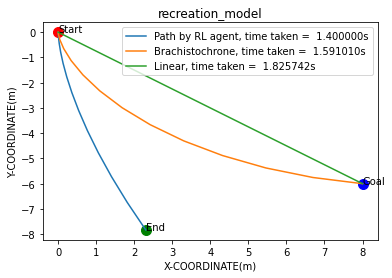

Goal reached! episodic-reward= -80.08765
Steps taken: 14
Time taken:  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


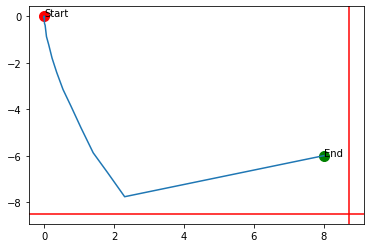

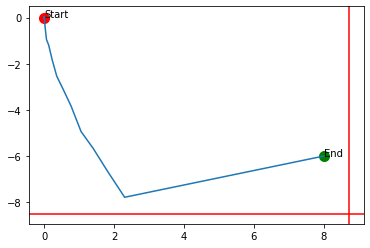

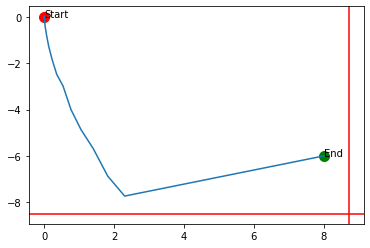

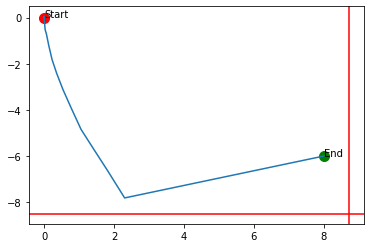

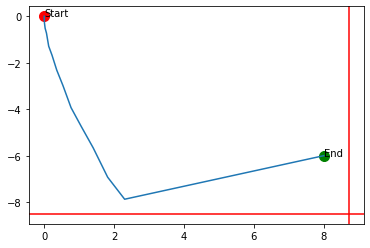

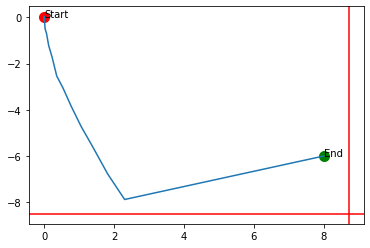

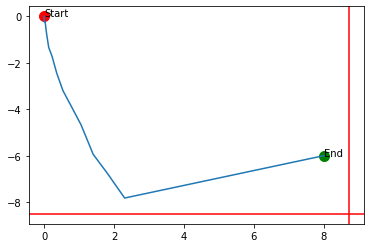

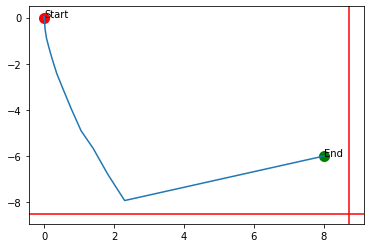

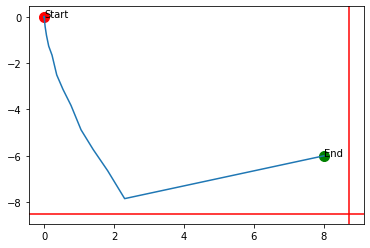

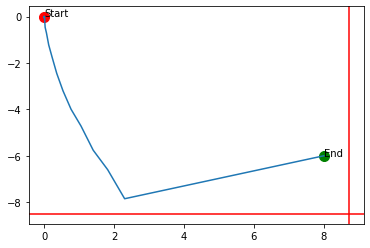

opt.cast_pop
[[[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00 -5.89347198e-02]
  [ 1.74086692e-03 -2.38425719e-02]
  [ 8.68976302e-03 -3.01284582e-01]
  [ 2.77516749e-02 -3.87480816e-01]
  [ 6.57469258e-02 -8.75169699e-01]
  [ 1.29378721e-01 -1.22207227e+00]
  [ 2.25200757e-01 -1.79924383e+00]
  [ 3.59585494e-01 -2.42169565e+00]
  [ 5.38693309e-01 -3.15016753e+00]
  [ 7.68442571e-01 -3.87462176e+00]
  [ 1.05448127e+00 -4.80396030e+00]
  [ 1.40215945e+00 -5.87608259e+00]
  [ 1.81650376e+00 -6.73486833e+00]
  [ 2.30219293e+00 -7.76676668e+00]
  [ 8.00000000e+00 -6.00000000e+00]]

 [[ 0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  5.62616301e-02]
  [ 1.74086692e-03 -3.74842937e-02]
  [ 8.68976302e-03 -1.02205753e-01]
  [ 2.77516749e-02 -4.26348258e-01]
  [ 6.57469258e-02 -9.47085816e-01]
  [ 1.29378721e-01 -1.19595771e+00]
  [ 2.25200757e-01 -1.80652641e+00]
  [ 3.59585494e-01 -2.53956722e+00]
  [ 5.38693309e-01 -3.09375924e+00]
  [ 7.68442571e-01 -3.83005458e+00]
  [ 1.0544812

In [16]:
RLOpt = RLBaseSolutionBuilder(Brachistochrone_Env,(8.0, -6.0)) #provide target position for initialization
SELECTED_MODEL = "recreation_model"
change_selected_model()

RLOpt.LoadAgentModel(SELECTED_MODEL) 
#IF YOU WANT YOU CAN TRAIN NEW AGENT FROM SCRATCH -> RLOpt.TrainNewAgent()
RLOpt.TrainNewAgent(model_name = SELECTED_MODEL)
RLOpt.ValidateAgent()#plot the trace corrinsponding to current loaded agent   !!!read me: LoadAgentModel and TrainNewAgent change current loaded model!!!
env = RLOpt.GetEnv()
solution_vector = RLOpt.GetBaseSolution() #get base solution for next pipeline step

#init population generation
opt = OptimizerMiddlewareManager(env,solution_vector,10) #0
opt.base_solution_cast() #1
opt.CreatePopInTranslatedDomain(0.01) #2
opt.TranslatedPopulationRender()

print("opt.cast_pop")
print(opt.cast_pop)
print("Population Size")
print(opt.cast_pop.shape[0])
print("Number of Points")
print(opt.cast_pop.shape[1])

## Genetic Algorithm with RL results

In [36]:
template_points = [np.array(list(zip(*individual))) for individual in opt.cast_pop]
template_points = np.array([[normalize(individual[0],0,1),normalize(individual[1],0,1)] for individual in template_points])
list_points = [ list(zip(individual[0],individual[1])) for individual in template_points]
list_points = np.array(list_points)

ga_n_individuals = opt.cast_pop.shape[0]
ga_n_points = opt.cast_pop.shape[1]

In [1]:
population = Population(Individual, 
                        random=ga_random,
                        n_individuals=ga_n_individuals, 
                        n_points=ga_n_points, 
                        height=ga_height, 
                        width=ga_width, 
                        show_plot=ga_show_plot, 
                        show_info=ga_show_info, 
                        show_debug=ga_show_debug)

# Preparation of environment folders 
makeFolders()
initConfig(folder=ga_misc_runs_dir, set_global=False)

GeneticAlgorithm(population=population,
                 n_generations=ga_n_generations,
                 objectives=ga_objectives,
                 misc_runs_dir=ga_misc_runs_dir,
                 evolution_dir=ga_evolution_dir,
                 objectives_dir=ga_objectives_dir,
                 ps=ga_ps,
                 pc=ga_pc,
                 pm=ga_pm,
                 p_variable=ga_p_variable,
                 show_plot=ga_show_plot,
                 show_info=ga_show_info, 
                 show_debug=ga_show_debug)

NameError: ignored